In [2]:
import dataset as D
import util as U
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import sys
import torch
#[... more imports ...]
sys.path.append('/Users/abdielfer/RNCanWork/DL4Flood/')
# and then, the subfolder import:
from model_set.models import UNetFlood
list_path = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/template_project_feat1_min-annot1_trn.csv'
 
dataset = D.customDataSet(list_path, True)
print(f" Len mask list:{len(dataset.mask_list)} and len ima_list: {len(dataset.img_list)}")

args = {'savepath':list_path, 'batch_size': 1, 'num_workers': 0,'drop_last':False}

train_set = D.customDataloader(dataset,args).getDataloader()


 Len mask list:17 and len ima_list: 17


img shape at read time (1, 380, 380)
mask shape at read time (1, 380, 380)
img shape at dataLoader delivery time torch.Size([1, 380, 380])
mask shape at dataLoader delivery time torch.Size([1, 380, 380])
img shape at read time (1, 380, 380)
mask shape at read time (1, 380, 380)
img shape at dataLoader delivery time torch.Size([1, 380, 380])
mask shape at dataLoader delivery time torch.Size([1, 380, 380])
image to model input shape torch.Size([1, 1, 380, 380])


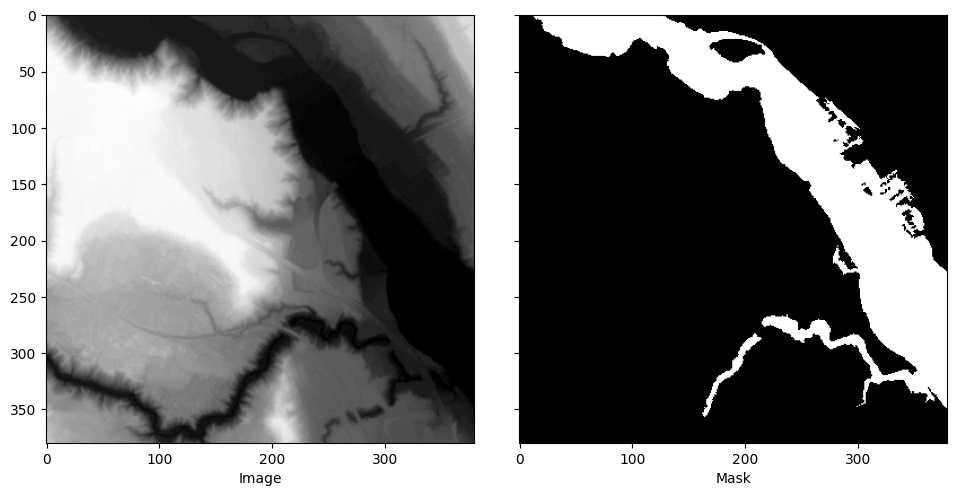

In [3]:
item = next(iter(train_set))
imag = item[0]
mask = item[1]
print('image to model input shape',imag.shape)
U.plotImageAndMask(imag[0][0], mask[0][0])

In [4]:
model = UNetFlood(1,1)
Y_hat = model(imag)
# print('y_hat shape',Y_hat.shape,'mask shape',mask.shape)
# U.plotImageAndMask(Y_hat[0][0], mask[0][0])

maxpool4 torch.Size([1, 512, 23, 23])
decode1 torch.Size([1, 64, 368, 368])
decode2 torch.Size([1, 128, 184, 184])


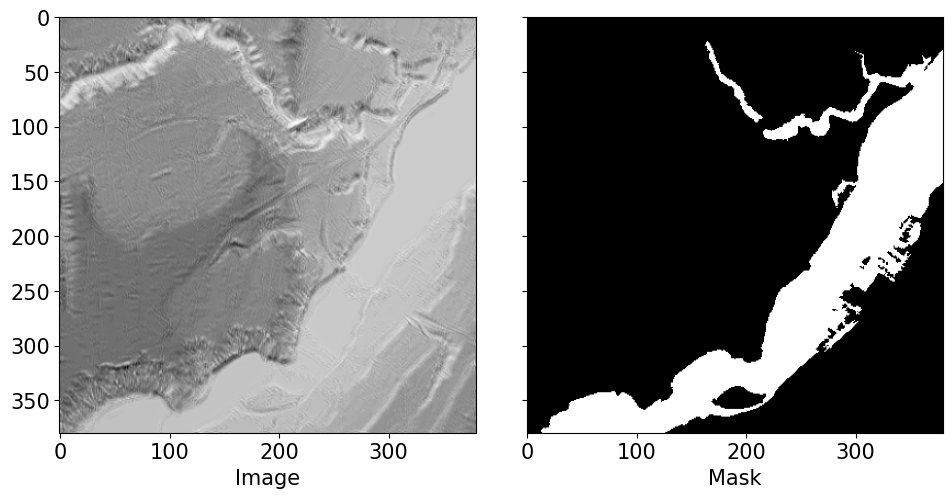

In [23]:
####   Apply sigmoid to the output image to compare with Mask...IMportant!!!!
y_hatSigmoided = torch.sigmoid(Y_hat[0][0])

U.plotImageAndMask(y_hatSigmoided, mask[0][0])

In [ ]:
### Visualize all batch image-mask pairs. 
# NOTE :   img, mask = next(iter(train_set))
i = 0
j = 0
for batch in train_set:
    for item in batch:
        print(f"Bathc {i}, item {j}")
        print('item',item.shape)
        j +=1
        
    # U.plotImageAndMask(batch[0][0],batch[1][0])
    i+=1
    j=0  
    print("_______") 


In [ ]:
## Ref: 

from typing import Iterable, List
import torch
import matplotlib.pyplot as plt

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='gray')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

In [ ]:

from pathlib import  Path
import xarray as xr
import matplotlib.pyplot as plt

root = Path('dset-s2')
assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()
     

idx = 0
img = xr.open_rasterio(train_imgs[idx])
mask = xr.open_rasterio(train_masks[idx])
_, axs = plt.subplots(1, 2, figsize=(15, 6))

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/3000
axs[0].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap='Blues')